In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import math
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

[-1, 110, 0, 6.5]

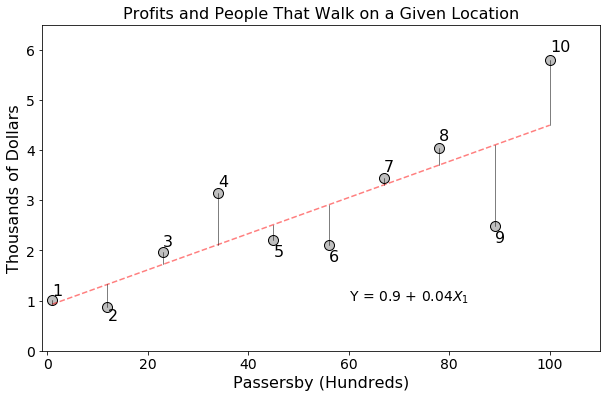

In [43]:
np.random.seed(5212019)
N_stores = 10
customers = np.linspace(1,100,N_stores).reshape((N_stores,1))
revenue   = 0.2*customers
cost      = 0.15*customers
profits   = revenue - cost + np.random.randn(N_stores).reshape((N_stores,1))
fig, ax = plt.subplots(figsize=(10,6), frameon=False)
plt.scatter(customers, profits, s=100, edgecolor='k', facecolor='0.75')
ax.set_ylabel('Thousands of Dollars', fontsize=16)
ax.set_xlabel('Passersby (Hundreds)', fontsize=16)
ax.set_title('Profits and People That Walk on a Given Location', fontsize=16)
ax.set_xticklabels(np.arange(-20,101,20), fontsize=14)
ax.set_yticklabels(np.arange(0,7,1), fontsize=14)
# Run OLS
mylinear_reg = reg = LinearRegression(fit_intercept=True).fit(customers, profits)
yhat = mylinear_reg.predict(customers)
ax.plot(customers, yhat, color='r', alpha=0.5, ls='--')

for i in range(N_stores):
    if profits[i]<yhat[i]:
        ax.text(customers[i], 0.96*profits[i], str(i+1), fontsize=16, 
                 verticalalignment='top', horizontalalignment='left')
    else:
        ax.text(customers[i], 1.02*profits[i], str(i+1), fontsize=16, 
                 verticalalignment='bottom', horizontalalignment='left')  

# parameters
constant = mylinear_reg.intercept_[0]
slope = mylinear_reg.coef_[0,0]
str_reg = ('Y = ' + str(np.around(constant, decimals=1)) + ' + ' + 
                       str(np.around(slope, decimals=2)) + '$X_1$')
plt.text(60,1, str_reg, color='k', fontsize=14)
    
ax.axis([-1,110, 0, 6.5])
# get error bars
for i in range(N_stores):
    plt.plot([customers[i],customers[i]],[profits[i], yhat[i]], color='k', lw=0.5)
    
        
ax.axis([-1,110, 0, 6.5])

# Frisch-Waugh-Lovell Theorem

The FWL theorem tells us that we can interpret the OLS coefficients as net effects from other control variables or confounders
For instance, in
$$
y = \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + \epsilon
$$

$\hat{\alpha}_2$ is the marginal effect of $x_2$ on $y$ _controlling_ for $x_1$

This can be seen by estimating the following regressions:

1. Regress $y$ on $x_1$ and a constant/intercept
    * Save residuals = $\hat{\nu}$
2. Regress $x_2$ on $x_1$ and a constant/intercept
    * Save residuals = $\hat{\mu}$
3. Regress $\hat{\nu}$ on $\hat{\mu}$ and a constant/intercept
    * Coefficient on $\hat{\mu}$ will be exactly equal to $\hat{\alpha}_2$ from the full OLS regression
    
**Note**: FWL _doesn't_ suggest that we replace the one-step OLS regression on all variables for several three-step regressions.  It's useful for _interpretation purporses only_.  In practice we never use it (but you can check that when estimating Generalized Additive Models (GAMs) we use a similar iterative procedure to guarantee that we estimate net effects).

In [44]:
# Let's simulate some data to show how the theorem works
np.random.seed(562020)
N = 100
x1 = 2 + 0.01*np.random.randn(N,1)
x2 = -0.5 + 0.1*np.random.randn(N,1)
epsilon = 0.001*np.random.randn(N,1)
alpha1 = 2
alpha2 = -2
y = 0.5 + alpha1*x1 + alpha2*x2 + epsilon
# run a regression 
X = np.concatenate((x1,x2),axis=1)
reg = reg = LinearRegression(fit_intercept=True).fit(X, y)
alpha1_hat = reg.coef_[0,0]
alpha2_hat = reg.coef_[0,1]
intercept_hat = reg.intercept_[0]
print('alpha_1 = {0}, estimated alpha_1 = {1}'.format(alpha1, alpha1_hat))
print('alpha_2 = {0}, Estimated alpha_2 = {1}'.format(alpha2, alpha2_hat))

alpha_1 = 2, estimated alpha_1 = 1.9928013843349608
alpha_2 = -2, Estimated alpha_2 = -2.002193189274578


In [ ]:
# Now run pairwise regressions
reg1 = LinearRegression(fit_intercept=True).fit(x1, x2)
regy = LinearRegression(fit_intercept=True).fit(x1, y)
# compute residuals
resids1 = x2 - reg1.predict(x1)
residsy = y - reg1.predict(x1)
# final regression
reg_final = LinearRegression(fit_intercept=True).fit(resids1, residsy)
print('alpha2_hat from full regression = {0}'.format(alpha2_hat))
print('alpha2_hat from FWL regressions = {0}'.format(reg_final.coef_[0,0]))

# A/B testing

Computing the _Minimum Detectable Effect_.   In the text we used the following formula to compute the MDE:

$$
MDE = (t_{\alpha} + t_{1-\beta})\sqrt{\frac{\text{Var(Outcome)}}{N P(1-P)}}
$$

where $\alpha$ and  $1-\beta$ are the size and power of the test, respectively, $N$ is the number of customers in the tests, $P$ is the fraction of customers in the treatment group (the remaining goes to the control group) and $\text{Outcome}$ is the metric that we are testing (e.g. conversion rates, revenues, ticket, etc.)


The following code was used as a sample size calculator in the text

In [157]:
def calculate_sample_size(var_outcome, size, power, MDE):
    '''
    Function to calculate the sample size for an A/B test
    MDE = (t_alpha + t_oneminusbeta)*np.sqrt(var_outcome/(N*P*(1-P))) 
    df: degrees of freedom when estimating the variance of the outcome (usually large enough)
    '''
    df = 1000
    t_alpha = stats.t.ppf(1-size, df)
    t_oneminusbeta = stats.t.ppf(power, df)
    # same number of customers in treatment and control group
    P = 0.5
    N = ((t_alpha + t_oneminusbeta)**2 * var_outcome)/(MDE**2 * P * (1-P))
    return N

var_y = 4500
size = 0.05
power = 0.8
MDE = 10
sample_size_for_experiment = calculate_sample_size(var_y, size, power, MDE)
print('We need at least {0} customers in experiment'.format(np.around(sample_size_for_experiment),decimals=0))

We need at least 1115.0 customers in experiment


Let's understand where this formula comes from.  It takes three steps:

1. **Step 1**: We want to divide the sample into _treatment_ and _control_ groups.  Let's denote the Outcome as $Y$.  We care about the difference in outcomes across groups:

$$
\theta = \overline{Y}_T - \overline{Y}_C
$$

If $\theta=0$ then our treatment had no effect.

2. **Step 2**: 

$$
Var(\theta) = Var(\overline{Y}_T) + Var(\overline{Y}_C)) = \frac{\sigma}{N_T} + \frac{\sigma}{N_C} = \frac{\sigma}{NP(1-P)}
$$

    * The first equality (from left to right) follows from the properties of the variance and independence across groups from randomization.  
    * The second equality follows from the fact that the variance of the sample mean (from a random sample of observations, guaranteed again by randomization) can always be expressed like that, where $\sigma$ is the variance of the metric we are using to decide if the test worked or not.
    * The final equality follows from doing some algebra: $N_T = NP$ and $N_C = (1-P)N$ and then just factoring out and doing some algebra.

3. **Step 3**:
$$
MDE  = (t_\alpha + t_{1-\beta})\sqrt{Var(\theta)}
$$

Let's understand why this last equality is true.

**Figure 1** below shows the distribution of _normalized_ $\theta$ under the assumption (null hypothesis) that there is no difference between treatment and control (so it's centered in 0).  The size $\alpha$ is the probability of a false positive: whenever our test statistic (average difference divided by the standard error) is to the left of $t_{\alpha}$ we reject the hypothesis of no effect.  

* It follows that the minimum _normalized_ effect where we can reject the null hypothesis of no effect is $t_{\alpha}$

**Figure 2** does the following calibration.  Given $t_{\alpha}$ we wish to find the (unique) distribution to the right of the distribution under the null such that the area under the left tail of the distribution _starting at $t_{\alpha}$_ is exactly equal to $\beta$.

* Note that this distribution is unique (since the distribution of $\theta$ is Normal and the test statistic follows a _t_ distribution -- this will play an important role in the next step): we are essentially moving it left and right finding the exact number to center it such that the area of the left tail is $\beta$.

* Also note that _under the assumption that there is a positive effect_ (think of it as the alternative hypothesis), $\beta$ is the probability of a _false negative_. Any statistic that falls in that region would lead us to falsely reject this alternative hypothesis.  It follows that $1-\beta$ is the power of the statistic: under the alternative hypothesis, anything that falls in this region (to the right of $t_{\alpha}$) would lead us the (correctly) not reject the alternative. 

**Final note**:
This plot is in the normalized view: the effect $\theta$ is divided by the standard deviation $\sigma$.

In this world, the construction allows us to conclude that $MDE*=(t_{\alpha} + t_{1-\beta})$.  _But our effects are in the unnormalized world_, so we need to multiply by the standard deviation of our outcome.

[-4, 4, 0, 0.45]

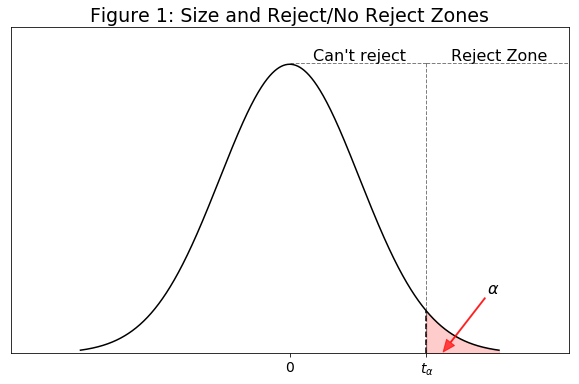

In [170]:
nobs=1000
mu1 = 0
variance = 1
sigma = np.sqrt(variance)
x1 = np.linspace(mu1 - 3*sigma, mu1 + 3*sigma, nobs)
x2 = np.linspace(mu2 - 3*sigma, mu2 + 3*sigma, nobs)
fig, ax = plt.subplots(figsize=(10,6))
density1 = stats.norm.pdf(x1, mu1, sigma)
ax.plot(x1, density1, color='k')
# plot size first
alpha=0.05
t_alpha = norm.ppf(1 - alpha / 2.)
ax.fill_between(x1,density1,0, where= x1>=t_alpha, color='r', alpha=0.2)
ax.plot([t_alpha,t_alpha],[0,stats.norm.pdf(t_alpha,mu1,sigma)], ls='--', color='k')
ax.plot([t_alpha,t_alpha],[0,0.40], ls='--', color='k', alpha=0.5, lw=1)
ax.plot([0,t_alpha],[0.4,0.40], ls='--', color='k', alpha=0.5, lw=1)
ax.text(1,0.4,"Can't reject", fontsize=16, verticalalignment='bottom', horizontalalignment='center')
ax.plot([t_alpha,4],[0.4,0.40], ls='--', color='k', alpha=0.5, lw=1)
ax.text(3,0.4,"Reject Zone", fontsize=16, verticalalignment='bottom', horizontalalignment='center')
ax.annotate(r'$\alpha$', xy=(2.2, 0.002),
            xytext=(3, 0.1),
            arrowprops=dict(edgecolor='r',facecolor='r', shrink=1,width=1,headwidth=10,alpha=0.7),
            horizontalalignment='right', verticalalignment='top',
            fontsize=16)
ax.set_xticks([0,t_alpha])
ax.set_xticklabels([0,r'$t_{\alpha}$'], fontsize=14)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_title('Figure 1: Size and Reject/No Reject Zones', fontsize=19)

ax.axis([-4,4,0,0.45])

[-3.51, 7.71, 0, 0.45]

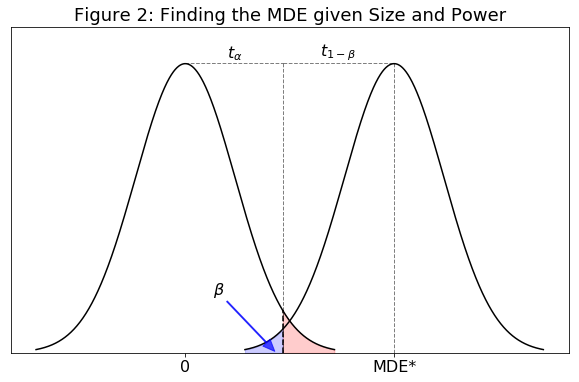

In [174]:
nobs=1000
mu1 = 0
mu2 = 4.2
variance = 1
sigma = math.sqrt(variance)
x1 = np.linspace(mu1 - 3*sigma, mu1 + 3*sigma, nobs)
x2 = np.linspace(mu2 - 3*sigma, mu2 + 3*sigma, nobs)
fig, ax = plt.subplots(figsize=(10,6))
density1 = stats.norm.pdf(x1, mu1, sigma)
density2 = stats.norm.pdf(x2, mu2, sigma)
ax.plot(x1, density1, color='k')
ax.plot(x2, density2, color='k')
# plot size first
alpha=0.05
t_alpha = norm.ppf(1 - alpha / 2.)
ax.fill_between(x1,density1,0, where= x1>=t_alpha, color='r', alpha=0.2)
ax.plot([t_alpha,t_alpha],[0,stats.norm.pdf(t_alpha,mu1,sigma)], ls='--', color='k')
ax.plot([t_alpha,t_alpha],[0,0.40], ls='--', color='k', alpha=0.5, lw=1)
ax.plot([0,t_alpha],[0.4,0.40], ls='--', color='k', alpha=0.5, lw=1)
ax.text(1,0.4,r'$t_{\alpha}$', fontsize=16, verticalalignment='bottom', horizontalalignment='center')
# plot power now
ax.fill_between(x2,density2,0, where= x2<=t_alpha, color='b', alpha=0.2)
ax.annotate(r'$\beta$', xy=(1.8, 0.002),
            xytext=(0.8, 0.1),
            arrowprops=dict(edgecolor='b',facecolor='b', shrink=1,width=1,headwidth=10,alpha=0.7),
            horizontalalignment='right', verticalalignment='top',
            fontsize=16)
ax.plot([mu2,mu2],[0,0.40], ls='--', color='k', alpha=0.5, lw=1)
ax.plot([t_alpha,mu2],[0.4,0.40], ls='--', color='k', alpha=0.5, lw=1)
ax.text((t_alpha+mu2)*0.5,0.4,r'$t_{1-\beta}$', fontsize=16, verticalalignment='bottom', horizontalalignment='center')
ax.set_xticks([0,mu2])
ax.set_xticklabels([0,'MDE*'], fontsize=16)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_title('Figure 2: Finding the MDE given Size and Power', fontsize=18)

xmin,xmax= ax.get_xlim()
ax.axis([xmin,xmax,0,0.45])